In [3]:
import astropy.coordinates as coord
from astropy.io import ascii
from astropy.table import join, Table, Column
import astropy.units as u
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

I downloaded the 3 Bergemann tables from "Extended Data Tables" in [Bergemann et al. 2018](https://www.nature.com/articles/nature25490.pdf) by taking screenshots and using OCR to turn the screenshots into text. hashtag astronomy.

In [4]:
tbl = None
for i in range(1, 3+1):
    filename = '../data/Bergemann{0}.txt'.format(i)
    
    if i == 1:
        tbl = ascii.read(filename)
    else:
        tbl = join(tbl, ascii.read(filename), keys='2MASS_ID')
        
tbl.write('../data/Bergemann2018.csv')

I downloaded the A13 master table from Ting's paper [Li et al. 2017](http://iopscience.iop.org/0004-637X/844/1/74/suppdata/apjaa7a0dt1_ascii.txt).

In [5]:
tbl = ascii.read('../data/Li2017-A13.txt')

c = coord.SkyCoord(ra=coord.Angle(tbl['ra'], unit=u.hourangle),
                   dec=coord.Angle(tbl['dec'], unit=u.degree),
                   frame='fk5').transform_to(coord.ICRS)
tbl['ra'] = c.ra.degree
tbl['dec'] = c.dec.degree
tbl.write('../data/Li2017-A13.csv', overwrite=True)

I downloaded the TriAnd master table from Allyson's paper [Sheffield et al. 2014](http://iopscience.iop.org/article/10.1088/0004-637X/793/1/62/meta), removed all dwarf (D) stars, and removed the Triand1/2 distinction:

In [6]:
tbl = ascii.read('../data/Sheffield2014-TriAnd.txt')

all_ra = []
all_dec = []
for row in tbl:
    _ra = row['2MASS_ID'][:7]
    _dec = row['2MASS_ID'][7:]
    ra = coord.Longitude(':'.join([_ra[:2], _ra[2:4], '.'.join([_ra[4:6], _ra[6]])]), 
                         unit=u.hourangle)
    dec = coord.Latitude(':'.join([_dec[:3], _dec[3:5], _dec[5:]]),
                         unit=u.degree)
    all_ra.append(ra)
    all_dec.append(dec)

c = coord.SkyCoord(ra=coord.Longitude(all_ra),
                   dec=coord.Latitude(all_dec),
                   frame='fk5').transform_to(coord.ICRS)
    
tbl['ra'] = c.ra.degree
tbl['dec'] = c.dec.degree
tbl.write('../data/Sheffield2014-TriAnd.csv', overwrite=True)

---

### Gaia cross-matches

In [7]:
from pyia import GaiaData
from fuzzywuzzy import fuzz # OMG ALLY WHY

/Users/adrian/anaconda/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [8]:
berg = Table.read('../data/Bergemann2018.csv')

In [9]:
sheff_gaia = Table.read('../data/Sheffield2014-xmatch-result.fits.gz')

delete_ids = []
for _id in ['2317414+311304', '0051100+463939']:
    rows = sheff_gaia[sheff_gaia['col2mass_id'] == _id]
    delete_ids.append(rows[rows['phot_rp_mean_mag'].argmax()]['source_id'])
sheff_gaia = sheff_gaia[~np.isin(sheff_gaia['source_id'], delete_ids)]
sheff_gaia.rename_column('col2mass_id', '2MASS_ID')

In [10]:
sheff = Table.read('../data/Sheffield2014-TriAnd.csv')
sheff.remove_columns(['ra', 'dec', 'l', 'b'])
assert len(np.unique(sheff_gaia['source_id'])) == len(sheff)

sheff_master = join(sheff_gaia, sheff, keys='2MASS_ID')
sheff_master['2MASS_ID'] = Column(sheff_master['2MASS_ID'], dtype='<U16')

# Now add the Bergemann columns:
for _id in berg['2MASS_ID'][np.array(['TriAnd' in x for x in berg['name']])]:
    ratios = [fuzz.ratio(_id, x) for x in sheff['2MASS_ID']]
    sheff_master['2MASS_ID'][np.argmax(ratios)] = _id

sheff_master = join(sheff_master, berg, keys='2MASS_ID', join_type='left',
                    uniq_col_name='{table_name}{col_name}', table_names=['', 'berg'])

In [11]:
li = Table.read('../data/Li2017-A13.csv')
li.remove_columns(['ra', 'dec', 'l', 'b'])

li_gaia = Table.read('../data/Li2017-xmatch-result.fits.gz')

# Throw away A13-39 because it could be a binary:
li_gaia = li_gaia[li_gaia['name'] != 'A13-39']

li_master = join(li_gaia, li, keys='name')

# Finally, add the Bergemann columns:
li_master = join(li_master, berg, keys='name', join_type='left',
                 uniq_col_name='{table_name}{col_name}', table_names=['', 'berg'])

In [12]:
len(li_master), len(sheff_master)

(53, 91)

In [13]:
(np.isfinite(li_master['bergrv']).sum(), 
 np.isfinite(sheff_master['bergrv']).sum())

(6, 8)

### Add distances:

Assume [Fe/H] ~ -0.6 for all, then shrink distance by ~30% according to Bergemann.

Using M_Ks relation from Sheffield et al. 2014.

In [14]:
feh = -0.6

# Note: different corrections based on comparing against 1-to-1 line:
l17_dist = 0.7 * coord.Distance(distmod=li_master['Ks0'] - ((3.8 + 1.3*feh) - 8.4 * li_master['J-Ks0']))
s14_dist = 0.8 * coord.Distance(distmod=sheff_master['Ks0'] - ((3.8 + 1.3*feh) - 8.4 * sheff_master['J-Ks0']))

li_master['apw_distance'] = l17_dist.to_value(u.kpc)
sheff_master['apw_distance'] = s14_dist.to_value(u.kpc)

In [15]:
li_master.write('../data/Li2017-Gaia-master.fits', overwrite=True)
sheff_master.write('../data/Sheffield2014-Gaia-master.fits', overwrite=True)

## Compare Ally/Ting RVs to Maria RVs:

(-200, 100)

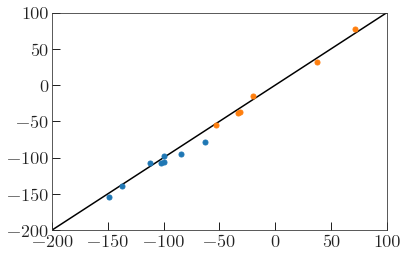

In [12]:
plt.scatter(sheff_master['rv'], 
            sheff_master['bergrv'])

plt.scatter(li_master['rv'], 
            li_master['bergrv'])

plt.plot(np.linspace(-200, 100, 128),
         np.linspace(-200, 100, 128),
         marker='', zorder=-100, color='k')
plt.xlim(-200, 100)
plt.ylim(-200, 100)

Compute RV error estimates:

In [27]:
np.std(sheff_master['rv'] - sheff_master['bergrv'])

6.154457226271055

In [28]:
np.std(li_master['rv'] - li_master['bergrv'])

4.692340093765111

## Metallicity distribution

(array([1., 1., 1., 3.]),
 array([-0.7 , -0.64, -0.58, -0.52, -0.46]),
 <a list of 4 Patch objects>)

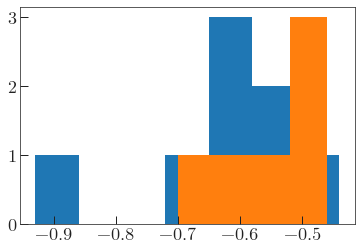

In [23]:
plt.hist(sheff_master[~sheff_master['bergrv'].mask]['fe_h'], bins='auto')
plt.hist(li_master[~li_master['bergrv'].mask]['fe_h'], bins='auto')

In [25]:
derp = np.concatenate((list(sheff_master[~sheff_master['bergrv'].mask]['fe_h']), 
                       list(li_master[~li_master['bergrv'].mask]['fe_h'])))
1.5 * np.median(np.abs(derp - np.median(derp)))

0.08249999999999999

In [26]:
DM = coord.Distance(10*u.kpc).distmod
coord.Distance(10*u.kpc) - coord.Distance(distmod=DM + 0.08*u.mag)

<Distance -0.37528416 kpc>

---